In [1]:
# pip install colorcet

In [2]:
import folium
import matplotlib
import numpy as np
import colorcet
from matplotlib.pyplot import imread
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from folium import raster_layers
from folium import plugins
from folium import branca

In [3]:
image = '/notebooks/resources/gpm/gpm_1d.20190531.tif'

In [4]:
from osgeo import gdal,ogr,osr

def GetExtent(gt,cols,rows):
    ''' Return list of corner coordinates from a geotransform

        @type gt:   C{tuple/list}
        @param gt: geotransform
        @type cols:   C{int}
        @param cols: number of columns in the dataset
        @type rows:   C{int}
        @param rows: number of rows in the dataset
        @rtype:    C{[float,...,float]}
        @return:   coordinates of each corner
    '''
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([y,x])
            print (y,x)
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    ''' Reproject a list of x,y coordinates.

        @type geom:     C{tuple/list}
        @param geom:    List of [[x,y],...[x,y]] coordinates
        @type src_srs:  C{osr.SpatialReference}
        @param src_srs: OSR SpatialReference object
        @type tgt_srs:  C{osr.SpatialReference}
        @param tgt_srs: OSR SpatialReference object
        @rtype:         C{tuple/list}
        @return:        List of transformed [[x,y],...[x,y]] coordinates
    '''
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

raster=image
ds=gdal.Open(raster)

gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize

ext=GetExtent(gt,cols,rows)
print("ext = " + str(ext))

src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(ds.GetProjection())
# tgt_srs=osr.SpatialReference()
# tgt_srs.ImportFromEPSG(3857)
tgt_srs = src_srs.CloneGeogCS()

geo_ext=ReprojectCoords(ext,src_srs,tgt_srs)
print("geo_ext = " + str(geo_ext))

10.0 -180.0
-60.0 -180.0
-60.0 -30.0
10.0 -30.0
ext = [[10.0, -180.0], [-60.0, -180.0], [-60.0, -30.0], [10.0, -30.0]]
geo_ext = [[10.0, -180.0], [-60.0, -180.0], [-60.0, -30.0], [10.0, -30.0]]


In [5]:
!gdalinfo '/notebooks/resources/gpm/gpm_1d.20190531.tif'

Driver: GTiff/GeoTIFF
Files: /notebooks/resources/gpm/gpm_1d.20190531.tif
       /notebooks/resources/gpm/gpm_1d.20190531.tif.aux.xml
Size is 1500, 700
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.2572326660159,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-180.000000000000000,10.000000000000000)
Pixel Size = (0.100000000000000,-0.100000000000000)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_DATETIME=2019:06:01 13:35:13
  TIFFTAG_DOCUMENTNAME=/NRTPUB/imerg/gis/2019/05/3B-HHR-L.MS.MRG.3IMERG.20190531-S233000-E235959.1410.V06B.1day.tif
  TIFFTAG_IMAGEDESCRIPTION=DOI=10.5067/GPM/IMERG/3B-HH-L/06 DOIauthority=http://dx.doi.org/ DOIshortName=3IMERGHH_LATE Unit=0.1(mm) ScaleFactor=10
  TIFFTAG_RESOLUTIONUNIT=2 (pixels/inch)
  TIFFTAG_SOFTWARE=IDL 8.7.2, Harris Geospatial Solutions, Inc.
  TIFFTAG_XRESOLUTION=1

In [6]:
# !gdal_edit -colorinterp_1 alpha /notebooks/resources/gpm/gpm_1d.20190531.tif

In [7]:
# Choose colormap
cmap = colorcet.cm.fire

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))


# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)



In [8]:
m = folium.Map(
      location = [-22, -114]
    , zoom_start = 2
    , control_scale = True 
    , tiles = 'Stamen Terrain'
)

data = matplotlib.pyplot.imread(image)

# Image bounds on the map in the form
# [[lat_min, lon_min], [lat_max, lon_max]]
m.add_child(raster_layers.ImageOverlay(
      data
    , opacity = 0.7
    , bounds = [ext[2], ext[0]]
    , mercator_project = True
#     , colormap = lambda x: (1, 0, 0, x)
    , colormap = colorcet.cm.fire
#     , colormap = branca.colormap.linear.PuBuGn_07.scale(0,700)
#     , colormap = my_cmap
)
           )

folium.Marker(
      ext[2]
    , popup = str(ext[2])
    , tooltip = str(ext[2])
).add_to(m)

folium.Marker(
      ext[0]
    , popup = str(ext[0])
    , tooltip = str(ext[0])
).add_to(m)

m

In [9]:
vars(m)

{'_children': OrderedDict([('stamenterrain',
               <folium.raster_layers.TileLayer at 0x7f8433aa8a58>),
              ('image_overlay_92155413a6b84d5387a381702772f37a',
               <folium.raster_layers.ImageOverlay at 0x7f83ebab7ac8>),
              ('marker_ac7d26db7daf4a5789ade1e0b5287481',
               <folium.map.Marker at 0x7f83ec59fc18>),
              ('marker_29b98858dab84a42ba7fd08322bdfefe',
               <folium.map.Marker at 0x7f83ebab7b38>)]),
 '_env': <jinja2.environment.Environment at 0x7f84047309e8>,
 '_id': '5302fb64bbe34b86b83a04708129f218',
 '_name': 'Map',
 '_parent': <branca.element.Figure at 0x7f8439e350b8>,
 '_png_image': None,
 'control_scale': True,
 'crs': 'EPSG3857',
 'global_switches': <folium.folium.GlobalSwitches at 0x7f8400474668>,
 'height': (100.0, '%'),
 'left': (0.0, '%'),
 'location': [-22, -114],
 'max_bounds': False,
 'max_lat': 90,
 'max_lon': 180,
 'min_lat': -90,
 'min_lon': -180,
 'no_wrap': False,
 'objects_to_stay_in_front': [

In [10]:
print(data)
print(data.shape)
# data = data.transpose()
# print(data)
# print(data.shape)

[[ 2  3  3 ...  0  0  0]
 [ 4  6  3 ...  0  0  0]
 [10  9  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  1  0  0]]
(700, 1500)


In [11]:
# First: read the geotiff image with GDAL.
from osgeo import gdal, osr

gdal.UseExceptions()

ds = gdal.Open(image)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print('\n\n## ds ##:\n\n' + str(ds))
print('\n\n## data ##:\n\n' + str(data))
print('\n\n## gt ##:\n\n' + str(gt))
print('\n\n## proj ##:\n\n' + str(proj))
print('\n\n## inproj ##:\n\n' + str(inproj))



## ds ##:

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f83ec88a8a0> >


## data ##:

[[ 2  3  3 ...  0  0  0]
 [ 4  6  3 ...  0  0  0]
 [10  9  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  1  0  0]]


## gt ##:

(-180.0, 0.1, 0.0, 10.0, 0.0, -0.1)


## proj ##:

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.2572326660159,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


## inproj ##:

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.2572326660159,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


In [12]:
q = lambda x: (0, 0, 0, 0)
print(q(0))

(0, 0, 0, 0)


In [13]:
cmap = colorcet.cm.bmw

rgba = cmap(0.5)
print(rgba) # (0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0
print(rgba[:-1])



(0.72312, 0.11873, 1.0, 1.0)
(0.72312, 0.11873, 1.0)


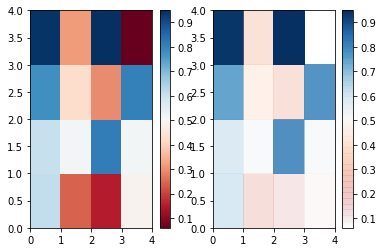

In [14]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

# Random data
data1 = np.random.random((4,4))

# Choose colormap
cmap = pl.cm.RdBu

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

pl.figure()
pl.subplot(121)
pl.pcolormesh(data1, cmap=pl.cm.RdBu)
pl.colorbar()

pl.subplot(122)
pl.pcolormesh(data1, cmap=my_cmap)
pl.colorbar()

[[0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.7065e-02 2.1430e-05 0.0000e+00 1.0000e+00]
 [5.2054e-02 7.4728e-05 0.0000e+00 1.0000e+00]
 ...
 [1.0000e+00 9.9953e-01 8.7115e-01 1.0000e+00]
 [1.0000e+00 9.9989e-01 9.3683e-01 1.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00]]


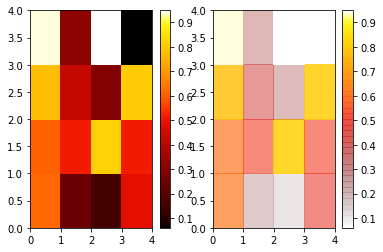

In [15]:
# Choose colormap
cmap = colorcet.cm.fire

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

print(my_cmap)

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

pl.figure()
pl.subplot(121)
pl.pcolormesh(data1, cmap=colorcet.cm.fire)
pl.colorbar()

pl.subplot(122)
pl.pcolormesh(data1, cmap=my_cmap)
pl.colorbar()

In [16]:
import branca
# branca.colormap.linear.Spectral_04
colormap = branca.colormap.linear.Spectral_04.scale(0, 10000)
colormap = colormap.to_step(index=[0, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000])
colormap.caption = 'mm'
colormap

In [17]:
import branca


colormap = branca.colormap.StepColormap(
    ['#64abb0','#9dd3a7', '#c7e9ad', '#edf8b9', '#ffedaa', '#fec980', '#f99e59', '#e85b3a', '#d7191c'],
    vmin=0, vmax=10000,
    index=[0, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000],
    caption='step'
)

colormap

In [18]:
cm.StepColormap(['#64abb0'])

NameError: name 'cm' is not defined

In [ ]:
ftp://jsimpson.pps.eosdis.nasa.gov/NRTPUB/imerg/gis/README.GIS.pdf